In [ ]:
# Install library dependencies (versions fixed to those used at time of publication)
#
%pip install DeepXDE==1.7.1

# Uncomment and run these lines if tensorflow, numpy, and matplotlib are not already installed.
# In most execution environments (Colab, tensorflow Docker image, etc.), these are already
# pre-installed on the OS.
#
#%pip install numpy==1.23.5 \
#             matplotlib==3.7.1 \
#             tensorflow==2.12.0

Reference wave height:


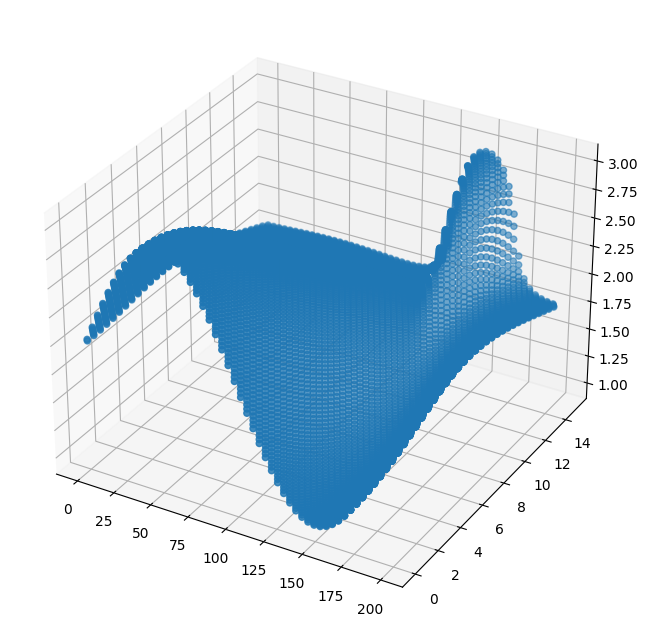

Reference velocity:


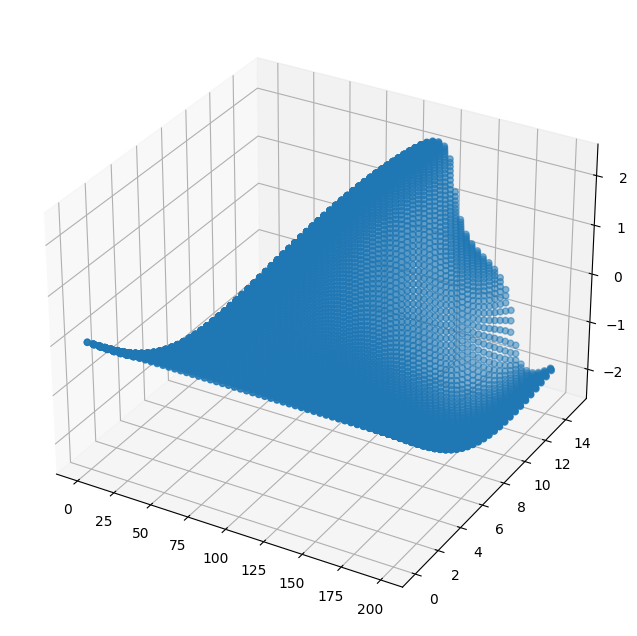

Reference bathymetry:


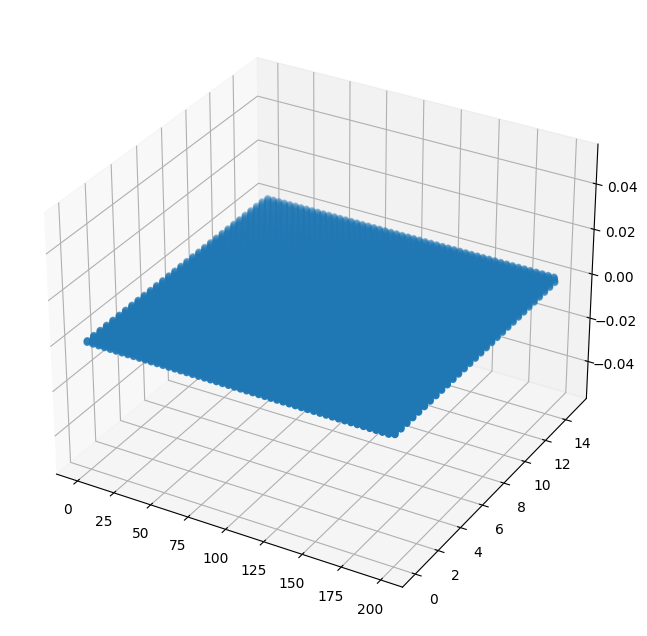

Set the default float type to float32
Compiling model...
Building feed-forward neural network...
'build' took 0.265548 s



2023-04-08 08:17:10.057931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-08 08:17:10.058247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-08 08:17:10.058392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'compile' took 1.070106 s

Initializing variables...
Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [3.89e-04, 9.69e+00, 2.75e+00, 1.36e-01, 5.41e-01, 8.41e-02, 2.90e-02, 2.69e-02, 2.69e+00, 1.58e+00]    [3.89e-04, 9.69e+00, 2.75e+00, 1.36e-01, 5.41e-01, 8.41e-02, 2.90e-02, 2.69e-02, 2.69e+00, 1.58e+00]    []  
1000      [7.04e-03, 7.49e-02, 3.91e-02, 3.38e-03, 1.91e-03, 1.00e-02, 4.63e-05, 7.04e-04, 3.03e-02, 8.01e-01]    [7.04e-03, 7.49e-02, 3.91e-02, 3.38e-03, 1.91e-03, 1.00e-02, 4.63e-05, 7.04e-04, 3.03e-02, 8.01e-01]    []  
2000      [8.15e-03, 1.01e-02, 3.53e-02, 3.66e-02, 8.33e-04, 1.40e-04, 1.95e-05, 4.93e-05, 2.42e-02, 1.27e+00]    [8.15e-03, 1.01e-02, 3.53e-02, 3.66e-02, 8.33e-04, 1.40e-04, 1.95e-05, 4.93e-05, 2.42e-02, 1.27e+00]    []  
3000      [3.61e-03, 8.03e-03

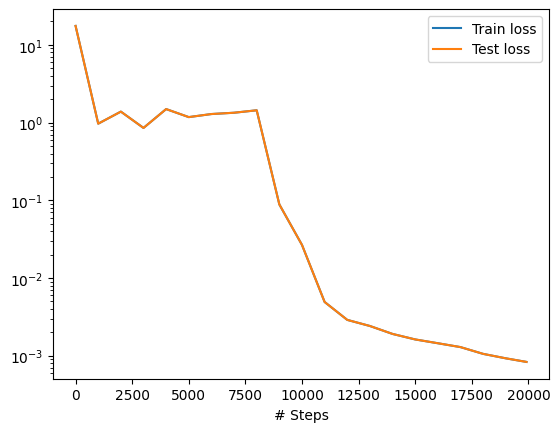

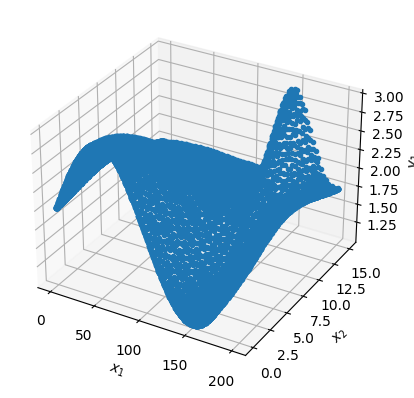

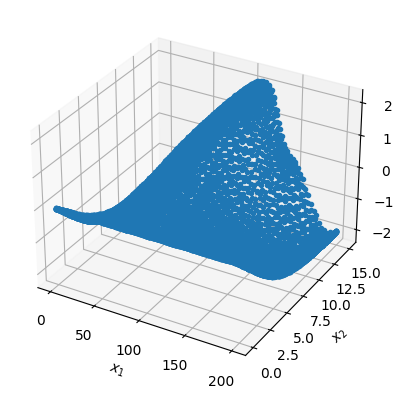

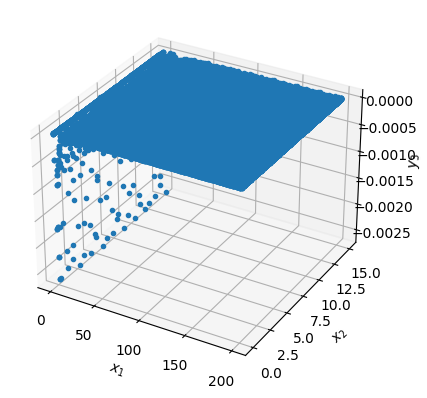

L2 relative error: 0.019328017779703836


In [10]:
import deepxde as dde
import numpy as np

from pinn import swe_1d
from csv_utils import load_data, plot_point_cloud, PhysicalQuantity

# Plot reference pseudospectral solution
#
print('Reference wave height:')
plot_point_cloud(load_data(), quantity=PhysicalQuantity.HEIGHT)
print('Reference velocity:')
plot_point_cloud(load_data(), quantity=PhysicalQuantity.VELOCITY)
print('Reference bathymetry:')
plot_point_cloud(load_data(), quantity=PhysicalQuantity.BATHYMETRY)

# Set random seed to 0 to allow for reproducable randomness in results
#
dde.config.set_random_seed(0)

# Set default float to 32-bit since Tensorflow seems to like that better
# when training on a GPU
#
dde.config.set_default_float('float32')

# Generate domain
#
x_min, x_max = (0, 200)
t_min, t_max = (0, 15)

geom = dde.geometry.Interval(x_min, x_max)
timedomain = dde.geometry.TimeDomain(t_min, t_max)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Point-set boundary condition for physical quantities of interest. In a real-world application, this might 
# correspond to measured data at specific collocation points.
#
observed_measurement_data = load_data(100)  # Load 100 random "measurements"

bc_h_obs = dde.icbc.PointSetBC(observed_measurement_data[:, 0:2], observed_measurement_data[:, 2:3], component=0)
bc_v_obs = dde.icbc.PointSetBC(observed_measurement_data[:, 0:2], observed_measurement_data[:, 3:4], component=1)
bc_alpha_obs = dde.icbc.PointSetBC(observed_measurement_data[:, 0:2], observed_measurement_data[:, 4:5], component=2)

# Periodic boundary conditions for height and velocity, respectively
#
bc_h = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, component=0, derivative_order=0)
bc_v = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, component=1, derivative_order=0) 

# Periodic boundary conditions for height and velocity derivatives, respectively
#
bc_h_x = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, component=0, derivative_order=1)
bc_v_x = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, component=1, derivative_order=1)

# Initial condition for wave height
#
ic_h = dde.icbc.IC(
    geomtime,
    lambda x: 2 + np.sin(x[:, 0:1] * np.pi / 100),
    lambda _, on_initial: on_initial,
    component=0,
)

# Initial condition for wave velocity
#
ic_v = dde.icbc.IC(
    geomtime,
    lambda x: 0,
    lambda _, on_initial: on_initial,
    component=1,
)

# Solve system with specified BCs and ICs
#
swe_1d(geomtime, [
    ic_h,
    ic_v
], [
    bc_h, 
    bc_v, 
    bc_h_x, 
    bc_v_x,
    bc_h_obs, 
    bc_v_obs,
#     bc_alpha_obs,
], samples=load_data(1000), iterations=10000)